/home/haoxiang/sam3/sam3/model_builder.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
INFO 2026-02-01 04:42:22,131 3327746 sam3_video_predictor.py: 300: using the following GPU IDs: [0, 1, 2, 3]
INFO 2026-02-01 04:42:22,132 3327746 sam3_video_predictor.py: 316: 


	*** START loading model on all ranks ***


INFO 2026-02-01 04:42:22,133 3327746 sam3_video_predictor.py: 318: loading model on rank=0 with world_size=4 -- this could take a while ...
INFO 2026-02-01 04:42:30,788 3327746 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-01 04:42:35,365 3327746 sam3_video_predictor.py: 320: loading model on rank=0 with world_size=4 -- DONE locally
INFO 2026-02-01 04:42:35,367 3327746 sam3_video_predictor.py: 377: spawning 3 worke

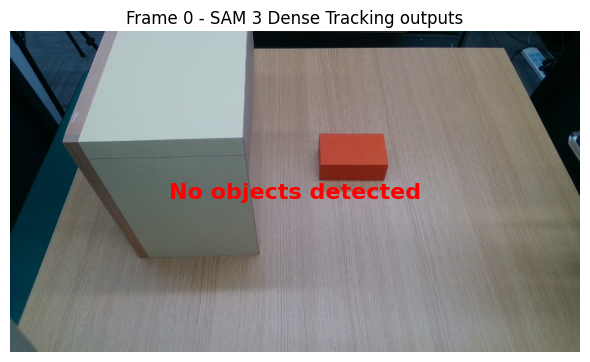

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4"
import sam3
import torch
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")
# video_path = f"{sam3_root}/assets/videos/camera0_rgb.mp4"
video_path = "/data/haoxiang/acp/flip_v3/scene_0001/cam_104122060902/color"

# use all available GPUs on the machine
gpus_to_use = range(torch.cuda.device_count())

from sam3.model_builder import build_sam3_video_predictor

predictor = build_sam3_video_predictor(checkpoint_path="/data/haoxiang/sam3/models/facebook/sam3/sam3.pt",gpus_to_use=gpus_to_use)

from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12

# 工具函数

def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.png"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.png" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

# # note: in case you already ran one text prompt and now want to switch to another text prompt
# # it's required to reset the session first (otherwise the results would be wrong)
# _ = predictor.handle_request(
#     request=dict(
#         type="reset_session",
#         session_id=session_id,
#     )
# )

# 开始使用prompt

prompt_text_str = "robot and cable"
# prompt_text_str = "robot arm with black cable"
# prompt_text_str = "black end-effector"
frame_idx = 0  # add a text prompt on frame 0

# 这里idx需要从0开始，不然之前的不识别

response = predictor.handle_request(
    request=dict(
        type="add_prompt", # 既然是add_prompt，这里其实是对这个predictor进行操作，request中内容会存储在class中
        session_id=session_id,
        frame_index=frame_idx,
        text=prompt_text_str,
    )
)
out = response["outputs"]

# 先画一张出来测试一下

plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: out})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

propagate_in_video:   0%|          | 0/201 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

201
{0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {0: array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}, 35: {0: array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}, 36: {0: array([

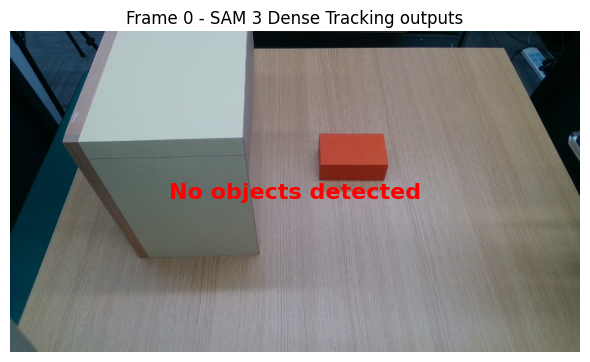

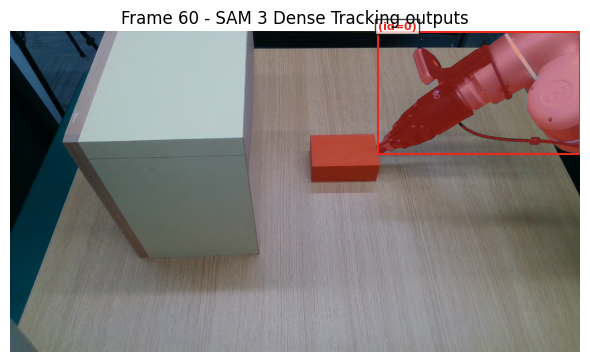

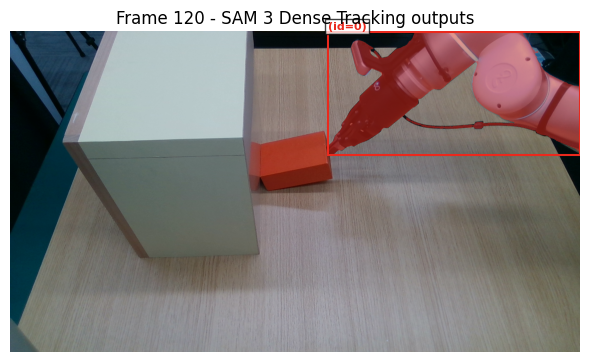

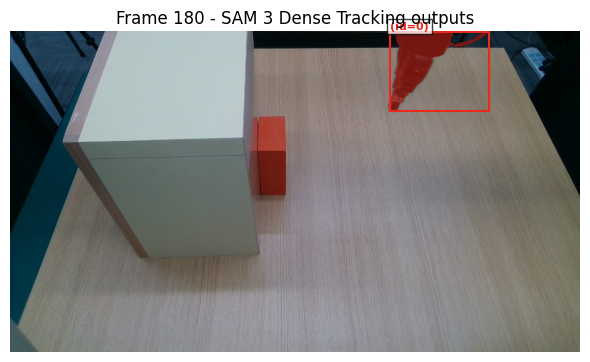

In [3]:
# response = predictor.handle_request(
#     request=dict(
#         type="remove_object",
#         session_id=session_id,
#         obj_id=1,
#     )
# )

# now we propagate the outputs from frame 0 to the end of the video and collect all outputs
outputs_per_frame = propagate_in_video(predictor, session_id)
print(len(outputs_per_frame))

# finally, we reformat the outputs for visualization and plot the outputs every 60 frames
outputs_per_frame = prepare_masks_for_visualization(outputs_per_frame)
print(outputs_per_frame)

vis_frame_stride = 60
plt.close("all")
for frame_idx in range(0, len(outputs_per_frame), vis_frame_stride):
    visualize_formatted_frame_output(
        frame_idx,
        video_frames_for_vis,
        outputs_list=[outputs_per_frame],
        titles=["SAM 3 Dense Tracking outputs"],
        figsize=(6, 4),
    )

In [5]:
# def save_masks_for_propainter(outputs_per_frame, video_frames, output_dir="propainter_masks"):
#     """
#     为 ProPainter 生成 mask 序列（空帧自动填充全黑）
    
#     Args:
#         outputs_per_frame: {frame_idx: {obj_id: binary_mask}} 
#         video_frames: 视频帧路径列表或已加载的帧数组列表
#         output_dir: 输出目录
#     """
#     os.makedirs(output_dir, exist_ok=True)
    
#     # 获取尺寸：直接用 PIL 打开第一张图（避免 load_frame 的类型问题）
#     first_frame = video_frames[0]
#     if isinstance(first_frame, str):
#         # 如果是路径，直接用 PIL 打开
#         sample_img = Image.open(first_frame)
#         img_width, img_height = sample_img.size
#     else:
#         # 如果已经是 numpy 数组，直接取 shape
#         if isinstance(first_frame, torch.Tensor):
#             first_frame = first_frame.cpu().numpy()
#         # 处理可能的 (H, W, 3) 或 (1, H, W, 3) 等情况
#         if first_frame.ndim == 4:
#             first_frame = first_frame[0]
#         img_height, img_width = first_frame.shape[0], first_frame.shape[1]
    
#     print(f"视频尺寸: {img_width}x{img_height}, 共 {len(video_frames)} 帧")
    
#     saved_paths = []
    
#     # 遍历所有帧，确保输出连续的帧序列
#     for frame_idx in range(len(video_frames)):
        
#         # 检查该帧是否有有效 mask
#         if frame_idx in outputs_per_frame and outputs_per_frame[frame_idx]:
#             obj_dict = outputs_per_frame[frame_idx]
            
#             # 初始化全黑图（0 表示背景）
#             combined_mask = np.zeros((img_height, img_width), dtype=np.uint8)
            
#             # 合并该帧所有对象（ProPainter 只需要知道"是否需要修复"）
#             for obj_id, mask in obj_dict.items():
#                 if isinstance(mask, torch.Tensor):
#                     mask = mask.cpu().numpy()
                
#                 # 确保是 2D 数组且为 bool 或 0/1
#                 if mask.ndim > 2:
#                     mask = mask.squeeze()
                
#                 # 任意对象为 True 的位置设为 255（需要修复区域）
#                 binary_mask = (mask > 0).astype(np.uint8) * 255
#                 combined_mask = np.maximum(combined_mask, binary_mask)
#         else:
#             # 空帧：全黑图（ProPainter 会跳过这些帧）
#             combined_mask = np.zeros((img_height, img_width), dtype=np.uint8)
        
#         # ProPainter 标准命名：00000.png, 00001.png...
#         filename = f"{frame_idx:05d}.png"
#         filepath = os.path.join(output_dir, filename)
#         Image.fromarray(combined_mask, mode='L').save(filepath)  # 'L' 表示灰度
#         saved_paths.append(filepath)
        
#         if frame_idx % 20 == 0:
#             has_target = (frame_idx in outputs_per_frame and outputs_per_frame[frame_idx])
#             status = "✓ 有目标" if has_target else "✗ 全黑"
#             print(f"处理帧 {frame_idx}/{len(video_frames)}: {status}")
    
#     print(f"\n完成！已生成 {len(saved_paths)} 张 mask 至: {os.path.abspath(output_dir)}")
#     return saved_paths


# # 使用示例（修复版）
# mask_paths = save_masks_for_propainter(
#     outputs_per_frame=outputs_per_frame,
#     video_frames=video_frames_for_vis,  # 你的视频帧路径列表
#     output_dir="/data/haoxiang/propainter/masks_scene0001"  # ProPainter 的 masks 路径
# )

def save_masks_for_propainter(outputs_per_frame, video_frames, output_dir="propainter_masks", 
                              dilate_radius=8):  # 新增参数：膨胀半径
    """
    为 ProPainter 生成 mask 序列，并进行膨胀处理。
    
    Args:
        outputs_per_frame: {frame_idx: {obj_id: binary_mask}} 
        video_frames: 视频帧路径列表或已加载的帧数组列表
        output_dir: 输出目录
        dilate_radius: 膨胀半径（像素）。值越大，Mask 扩得越粗。Mirage/ProPainter 一般建议 5-15 左右。
                       如果为 0 则不膨胀。
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # --- 1. 获取尺寸 ---
    first_frame = video_frames[0]
    if isinstance(first_frame, str):
        sample_img = Image.open(first_frame)
        img_width, img_height = sample_img.size
    else:
        if isinstance(first_frame, torch.Tensor):
            first_frame = first_frame.cpu().numpy()
        if first_frame.ndim == 4:
            first_frame = first_frame[0]
        img_height, img_width = first_frame.shape[0], first_frame.shape[1]
    
    print(f"视频尺寸: {img_width}x{img_height}, 共 {len(video_frames)} 帧")
    
    # --- 2. 准备膨胀 Kernel (核心修改部分) ---
    # Kernel 大小通常是 (2*radius + 1)，例如半径 5 对应 11x11 的核
    kernel = None
    if dilate_radius > 0:
        kernel_size = 2 * dilate_radius + 1
        # 创建矩形结构元素 (也可以用 cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ...) 创建圆形的)
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        print(f"启用 Mask 膨胀: 半径 {dilate_radius} (Kernel {kernel_size}x{kernel_size})")

    saved_paths = []
    
    for frame_idx in range(len(video_frames)):
        
        # --- 3. 生成基础 Mask ---
        # 初始化全黑图
        combined_mask = np.zeros((img_height, img_width), dtype=np.uint8)
        
        if frame_idx in outputs_per_frame and outputs_per_frame[frame_idx]:
            obj_dict = outputs_per_frame[frame_idx]
            
            for obj_id, mask in obj_dict.items():
                if isinstance(mask, torch.Tensor):
                    mask = mask.cpu().numpy()
                if mask.ndim > 2:
                    mask = mask.squeeze()
                
                # 合并 Mask
                binary_mask = (mask > 0).astype(np.uint8) * 255
                combined_mask = np.maximum(combined_mask, binary_mask)
        
        # --- 4. 执行膨胀 (核心修改部分) ---
        # 只有当 Mask 不是全黑时才膨胀
        if dilate_radius > 0 and np.any(combined_mask):
            # iterations=1 表示执行一次膨胀，配合 kernel 大小控制扩充程度
            combined_mask = cv2.dilate(combined_mask, kernel, iterations=1)

        # --- 5. 保存 ---
        filename = f"{frame_idx:05d}.png"
        filepath = os.path.join(output_dir, filename)
        Image.fromarray(combined_mask, mode='L').save(filepath)
        saved_paths.append(filepath)
        
        if frame_idx % 20 == 0:
            has_target = (frame_idx in outputs_per_frame and outputs_per_frame[frame_idx])
            status = "✓ 有目标" if has_target else "✗ 全黑"
            # print(f"处理帧 {frame_idx}/{len(video_frames)}: {status}")
    
    print(f"\n完成！已生成 {len(saved_paths)} 张 mask (膨胀半径={dilate_radius}) 至: {os.path.abspath(output_dir)}")
    return saved_paths

# --- 调用示例 ---
mask_paths = save_masks_for_propainter(
    outputs_per_frame=outputs_per_frame,
    video_frames=video_frames_for_vis,
    output_dir="/data/haoxiang/propainter/masks_scene0001",
    dilate_radius=10  # <--- 这里控制膨胀程度，一般 8-15 比较合适
)

视频尺寸: 1280x720, 共 201 帧
启用 Mask 膨胀: 半径 10 (Kernel 21x21)

完成！已生成 201 张 mask (膨胀半径=10) 至: /data/haoxiang/propainter/masks_scene0001


In [6]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()

INFO 2026-02-01 04:58:57,493 3327746 sam3_video_predictor.py: 251: removed session f7fbe01c-1331-4af4-9a71-7e1f17255805; live sessions: [], GPU memory: 7082 MiB used and 9022 MiB reserved (max over time: 8290 MiB used and 9022 MiB reserved)
INFO 2026-02-01 04:58:57,699 3327946 sam3_video_predictor.py: 251: removed session f7fbe01c-1331-4af4-9a71-7e1f17255805; live sessions: [], GPU memory: 5095 MiB used and 8540 MiB reserved (max over time: 7884 MiB used and 8540 MiB reserved)
INFO 2026-02-01 04:58:57,699 3327947 sam3_video_predictor.py: 251: removed session f7fbe01c-1331-4af4-9a71-7e1f17255805; live sessions: [], GPU memory: 5095 MiB used and 8540 MiB reserved (max over time: 7884 MiB used and 8540 MiB reserved)
INFO 2026-02-01 04:58:57,702 3327948 sam3_video_predictor.py: 251: removed session f7fbe01c-1331-4af4-9a71-7e1f17255805; live sessions: [], GPU memory: 5095 MiB used and 8540 MiB reserved (max over time: 7884 MiB used and 8540 MiB reserved)
INFO 2026-02-01 04:58:57,702 3327746